Použitá časová konstanta τ = 0.010 s → cutoff = 15.92 Hz
Lokální maxima:
1: t = 2.908, hodnota = 0.007
2: t = 3.092, hodnota = 0.007
3: t = 4.408, hodnota = 0.005
4: t = 4.592, hodnota = 0.005
5: t = 5.908, hodnota = 0.003
6: t = 6.092, hodnota = 0.003
7: t = 7.108, hodnota = 0.002
8: t = 7.292, hodnota = 0.002
9: t = 8.909, hodnota = 0.002
10: t = 9.091, hodnota = 0.002
Lokální minima:
1: t = 3.000, hodnota = -0.020
2: t = 4.500, hodnota = -0.013
3: t = 6.000, hodnota = -0.009
4: t = 7.200, hodnota = -0.007
5: t = 9.000, hodnota = -0.004


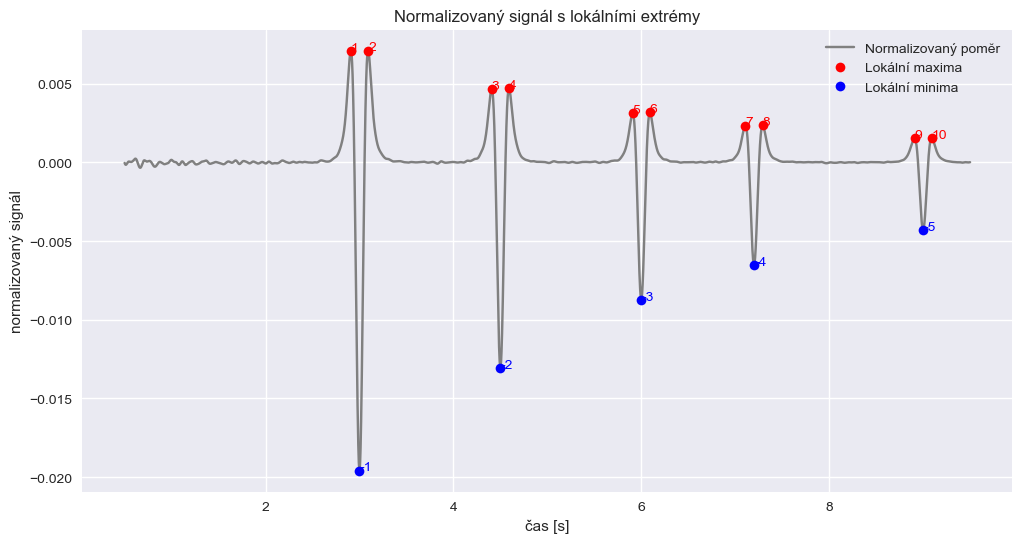

Amplitudy čar (2 maxima + 1 minimum):
1: mezi 2.908s a 3.092s (min v 3.000s) → A = 0.0267
2: mezi 4.408s a 4.592s (min v 4.500s) → A = 0.0177
3: mezi 5.908s a 6.092s (min v 6.000s) → A = 0.0119
4: mezi 7.108s a 7.292s (min v 7.200s) → A = 0.0089
5: mezi 8.909s a 9.091s (min v 9.000s) → A = 0.0058
Srovnání amplitud a FWHM:
Čára u 3.000s: A = 0.0267, I = 0.0150, A/I = 1.7793, FWHM_exp = 0.184, FWHM_theory = 0.138, FWHM_ratio = 1.33
Čára u 4.500s: A = 0.0177, I = 0.0100, A/I = 1.7733, FWHM_exp = 0.184, FWHM_theory = 0.138, FWHM_ratio = 1.33
Čára u 6.000s: A = 0.0119, I = 0.0067, A/I = 1.7729, FWHM_exp = 0.183, FWHM_theory = 0.138, FWHM_ratio = 1.33
Čára u 7.200s: A = 0.0089, I = 0.0050, A/I = 1.7729, FWHM_exp = 0.184, FWHM_theory = 0.138, FWHM_ratio = 1.34
Čára u 9.000s: A = 0.0058, I = 0.0033, A/I = 1.7723, FWHM_exp = 0.183, FWHM_theory = 0.138, FWHM_ratio = 1.32
Baseline std: 0.0015138561523082904


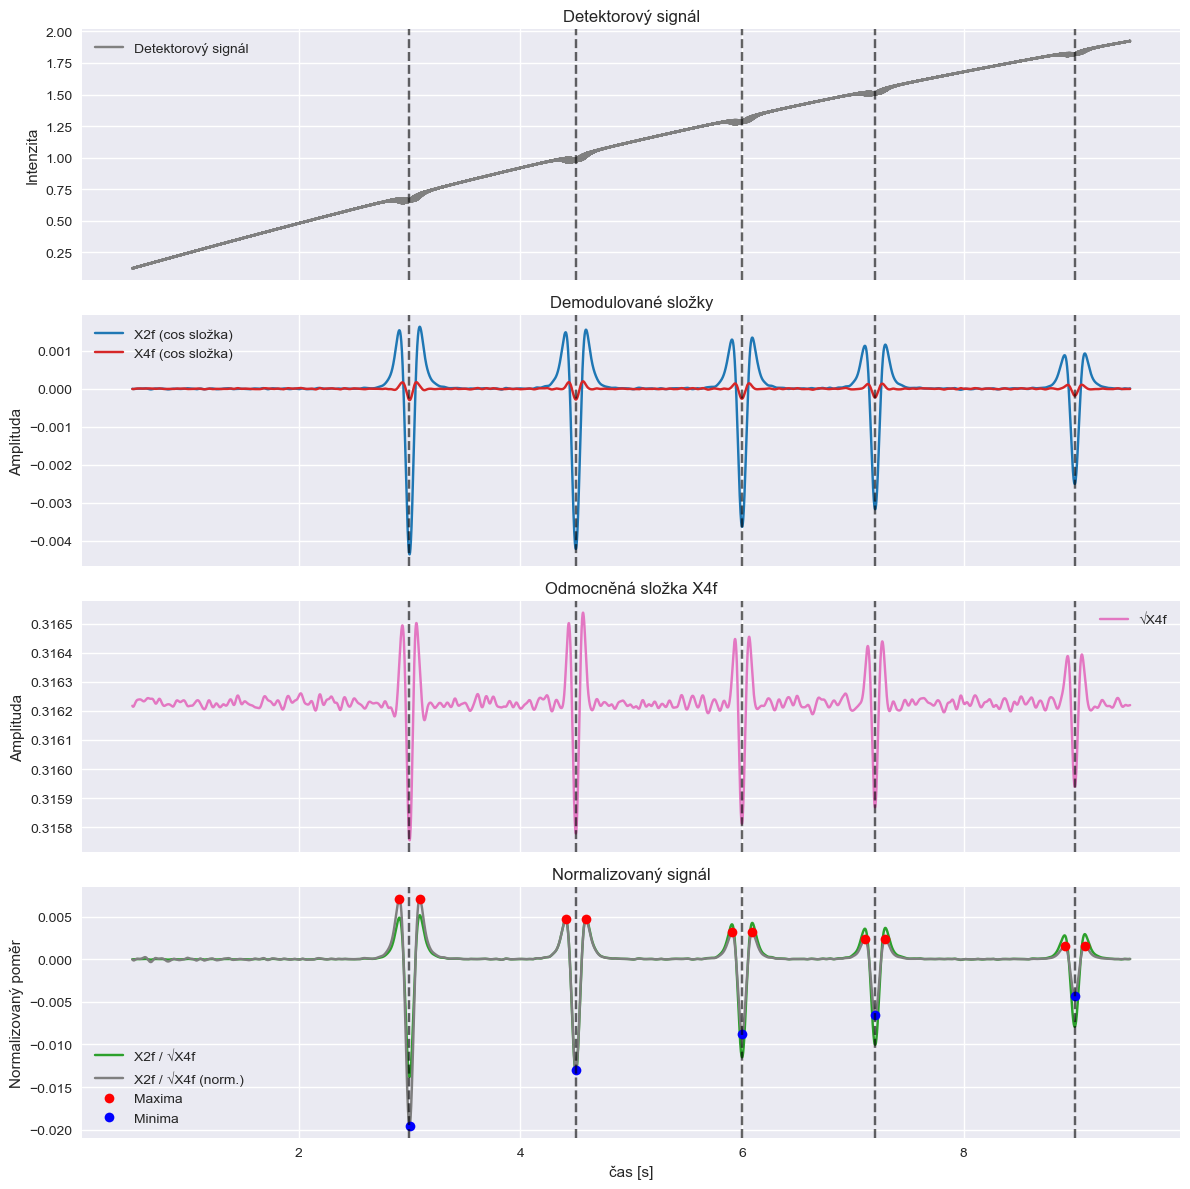

In [27]:
# ============================================
# Lock-in simulace s volitelným zadáním čar
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import wofz
from scipy.signal import butter, filtfilt, find_peaks
from scipy.optimize import curve_fit

# -----------------------------
# Parametry simulace
# -----------------------------
fs = 50000          # vzorkovací frekvence [Hz]
duration = 10.0     # délka [s]
t = np.linspace(0, duration, int(fs*duration))
n = len(t)

# -----------------------------
# Volba zdroje signálu
# -----------------------------
use_csv_signal = False   # True = načíst CSV, False = použít syntetický model
csv_file = "detector_signal.csv"

if use_csv_signal:
    # CSV musí mít sloupce: time, signal
    data = pd.read_csv(csv_file)
    t = data["time"].values
    signal_raw = data["signal"].values

    # Fit polynomem 4. stupně
    coeffs = np.polyfit(t, signal_raw, deg=4)
    poly_fit = np.polyval(coeffs, t)

    # Použijeme aproximovaný trend jako základní signál
    S_t = poly_fit

else:
    # Původní syntetická varianta
    S_t = 0.25 * t - 0.005 *t*t

# Modulační parametry
f_mod = 1234        # modulační frekvence [Hz]
mod_depth = 0.05
mod_signal = mod_depth * np.sin(2*np.pi*f_mod*t)
scan = t + mod_signal

# -----------------------------
# Definice čar
# -----------------------------
# Varianta 1: ruční zadání
# Každá položka: [pozice, intenzita, sigma, gamma]
lines_manual = [
    [3.0, 1.5e-2, 0.03, 0.05],
    [4.5, 1.0e-2, 0.03, 0.05],
    [6.0, 0.67e-2, 0.03, 0.05],
    [7.2, 0.5e-2, 0.03, 0.05],
    [9.0, 0.33e-2, 0.03, 0.05]
]

# Varianta 2: načtení z HITRAN-like CSV
# CSV musí mít sloupce: position, intensity, sigma, gamma
use_hitran = False   # <- přepínač: True = použít CSV, False = ruční zadání
hitran_file = "hitran_lines.csv"

if use_hitran:
    hitran_data = pd.read_csv(hitran_file)
    lines = hitran_data[["position", "intensity", "sigma", "gamma"]].values.tolist()
else:
    lines = lines_manual

# -----------------------------
# Voigtův profil a absorpce
# -----------------------------
def voigt(x, sigma, gamma):
    z = (x + 1j*gamma) / (sigma*np.sqrt(2))
    return np.real(wofz(z)) / (sigma*np.sqrt(2*np.pi))

def absorption_profile(scan, lines):
    absorption = np.zeros_like(scan)
    for xc, strength, sigma, gamma in lines:
        absorption += strength * voigt(scan - xc, sigma, gamma)
    return absorption

absorption = absorption_profile(scan, lines)

# -----------------------------
# Detektorový signál se šumem
# -----------------------------
noise_std = 0.0005
signal = S_t * (1 - absorption) + np.random.normal(0, noise_std, n)

# -----------------------------
# Adaptace časové konstanty τ
# -----------------------------
tau = 0.01  # časová konstanta lock-inu [s]
f_cut = 1/(2*np.pi*tau)   # mezní frekvence -3 dB
print(f"Použitá časová konstanta τ = {tau:.3f} s → cutoff = {f_cut:.2f} Hz")

def lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

# -----------------------------
# Lock-in demodulace
# -----------------------------
# 2f
fref2f = 2*f_mod
refcos2f = np.cos(2*np.pi*fref2f*t)
refsin2f = np.sin(2*np.pi*fref2f*t)
xraw2f = signal * refcos2f
yraw2f = signal * refsin2f
xfiltered = lowpass_filter(xraw2f, f_cut, fs)
yfiltered2f = lowpass_filter(yraw2f, f_cut, fs)

# 4f
fref4f = 4*f_mod
refcos4f = np.cos(2*np.pi*fref4f*t)
xraw4f = signal * refcos4f
xfiltered4f = lowpass_filter(xraw4f, f_cut, fs)

# -----------------------------
# Normalizace a poměry
# -----------------------------
def safe_divide(num, denom, eps=1e-12):
    return num / (denom + eps)
k=0.1
ratio = safe_divide(xfiltered, np.sqrt(xfiltered4f + k))
ratio_normalized = safe_divide(ratio, S_t)

# -----------------------------
# Hodnoticí kritéria
# -----------------------------
mask = (t >= 0.5) & (t <= 9.5)
t_sel = t[mask]
ratio_seln = ratio_normalized[mask]

# Nastav prahovou hodnotu (např. 0.002 = jen výrazné píky)
threshold = 0.001

min_time = 0.1  # sekundy
distance_int = int(min_time * fs)  # převedeno na vzorky

# Najdi lokální maxima nad prahem
peaks_max, props_max = find_peaks(ratio_seln, distance=distance_int, height=threshold)
peak_vals_max = ratio_seln[peaks_max]

# Najdi lokální minima pod -prahem (tj. dost hluboké záporné hodnoty)
peaks_min, props_min = find_peaks(-ratio_seln, distance=5000, height=threshold)
peak_vals_min = ratio_seln[peaks_min]

# Výpis hodnot
print("Lokální maxima:")
for i, idx in enumerate(peaks_max, 1):
    print(f"{i}: t = {t_sel[idx]:.3f}, hodnota = {ratio_seln[idx]:.3f}")

print("Lokální minima:")
for i, idx in enumerate(peaks_min, 1):
    print(f"{i}: t = {t_sel[idx]:.3f}, hodnota = {ratio_seln[idx]:.3f}")

# Vizualizace
plt.figure(figsize=(12,6))
plt.plot(t_sel, ratio_seln, color='grey', label='Normalizovaný poměr')

# maxima červeně
plt.plot(t_sel[peaks_max], ratio_seln[peaks_max], 'ro', label='Lokální maxima')
for i, idx in enumerate(peaks_max, 1):
    plt.text(t_sel[idx], ratio_seln[idx], f'{i}', color='red', fontsize=10)

# minima modře
plt.plot(t_sel[peaks_min], ratio_seln[peaks_min], 'bo', label='Lokální minima')
for i, idx in enumerate(peaks_min, 1):
    plt.text(t_sel[idx], ratio_seln[idx], f'-{i}', color='blue', fontsize=10)

plt.xlabel("čas [s]")
plt.ylabel("normalizovaný signál")
plt.title("Normalizovaný signál s lokálními extrémy")
plt.legend()
plt.show()

# --- Výpočet amplitud čar (2 maxima + 1 minimum) ---
amplitudes = []

# Seřadíme indexy podle času
all_max = sorted(peaks_max)
all_min = sorted(peaks_min)

for i in range(len(all_max)-1):
    left_max = all_max[i]
    right_max = all_max[i+1]

    # Najdi minima mezi těmito dvěma maximy
    local_minima = [m for m in all_min if left_max < m < right_max]
    if len(local_minima) == 0:
        continue  # žádné minimum mezi max → přeskoč

    # Vezmeme nejhlubší minimum mezi max
    min_idx = local_minima[np.argmin(ratio_seln[local_minima])]

    # Hodnoty
    val_left = ratio_seln[left_max]
    val_right = ratio_seln[right_max]
    val_min = ratio_seln[min_idx]

    # Amplituda = průměr obou maxim - minimum
    amplitude = ( (val_left + val_right)/2 ) - val_min

    amplitudes.append({
        "t_left_max": t_sel[left_max],
        "t_right_max": t_sel[right_max],
        "t_min": t_sel[min_idx],
        "amplitude": amplitude
    })

# Výpis výsledků
print("Amplitudy čar (2 maxima + 1 minimum):")
for i, amp in enumerate(amplitudes, 1):
    print(f"{i}: mezi {amp['t_left_max']:.3f}s a {amp['t_right_max']:.3f}s "
          f"(min v {amp['t_min']:.3f}s) → A = {amp['amplitude']:.4f}")

results = []

for amp in amplitudes:
    # Najdi nejbližší čáru podle pozice minima
    t_min = amp["t_min"]
    nearest_line = min(lines, key=lambda l: abs(l[0] - t_min))
    line_pos, line_intensity, sigma, gamma = nearest_line

    # Poměr amplitudy k intenzitě
    amp_ratio = amp["amplitude"] / line_intensity

    # Experimentální FWHM = vzdálenost mezi dvěma maximy
    fwhm_exp = amp["t_right_max"] - amp["t_left_max"]

    # Teoretická FWHM (aproximace Voigtova profilu)
    fwhm_theory = 0.5346*(2*gamma) + np.sqrt(0.2166*(2*gamma)**2 + (2.355*sigma)**2)

    fwhm_ratio = fwhm_exp / fwhm_theory

    results.append({
        "line_pos": line_pos,
        "intensity": line_intensity,
        "amplitude": amp["amplitude"],
        "amp_ratio": amp_ratio,
        "fwhm_exp": fwhm_exp,
        "fwhm_theory": fwhm_theory,
        "fwhm_ratio": fwhm_ratio
    })

# Výpis výsledků
print("Srovnání amplitud a FWHM:")
for r in results:
    print(f"Čára u {r['line_pos']:.3f}s: "
          f"A = {r['amplitude']:.4f}, I = {r['intensity']:.4f}, A/I = {r['amp_ratio']:.4f}, "
          f"FWHM_exp = {r['fwhm_exp']:.3f}, FWHM_theory = {r['fwhm_theory']:.3f}, "
          f"FWHM_ratio = {r['fwhm_ratio']:.2f}")


# Stabilita baseline
baseline_mask = ( (t_sel < 2.5) | ((t_sel > 3.5) & (t_sel < 5.5)) | 
                  ((t_sel > 6.5) & (t_sel < 8.5)) | (t_sel > 9.5) )
baseline_std = np.std(ratio_seln[baseline_mask])

print("Baseline std:", baseline_std)

# -----------------------------
# Vizualizace
# -----------------------------

# --- Výběr intervalu 0.5–9.5 s ---
mask = (t >= 0.5) & (t <= 9.5)
t_sel = t[mask]
signal_sel = signal[mask]
x2f_sel = xfiltered[mask]
x4f_sel = xfiltered4f[mask]
x4f_sqrt_sel = np.sqrt(xfiltered4f[mask] + 0.1)
ratio_sel = ratio[mask]
ratio_seln = ratio_normalized[mask]

# --- Vizualizace ---
plt.style.use('seaborn-v0_8')
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# 1. Detektorový signál
axs[0].plot(t_sel, signal_sel, color='gray', label='Detektorový signál')
axs[0].set_ylabel("Intenzita")
axs[0].set_title("Detektorový signál")
axs[0].legend()

# 2. Demodulované složky
axs[1].plot(t_sel, x2f_sel, label='X2f (cos složka)', color='tab:blue')
axs[1].plot(t_sel, x4f_sel, label='X4f (cos složka)', color='tab:red')
axs[1].set_ylabel("Amplituda")
axs[1].set_title("Demodulované složky")
axs[1].legend()

# 3. Odmocněná složka X4f
axs[2].plot(t_sel, x4f_sqrt_sel, label='√X4f', color='tab:pink')
axs[2].set_ylabel("Amplituda")
axs[2].set_title("Odmocněná složka X4f")
axs[2].legend()

# 4. Poměry a normalizace
axs[3].plot(t_sel, ratio_sel, label='X2f / √X4f', color='tab:green')
axs[3].plot(t_sel, ratio_seln, label='X2f / √X4f (norm.)', color='tab:grey')

# Pokud máš vypočtené maxima/minima, vykresli je
if 'peaks_max' in locals():
    axs[3].plot(t_sel[peaks_max], ratio_seln[peaks_max], 'ro', label='Maxima')
if 'peaks_min' in locals():
    axs[3].plot(t_sel[peaks_min], ratio_seln[peaks_min], 'bo', label='Minima')

axs[3].set_xlabel("čas [s]")
axs[3].set_ylabel("Normalizovaný poměr")
axs[3].set_title("Normalizovaný signál")
axs[3].legend()

# Svislé čáry pro čárové pozice
for ax in axs:
    for xc, strength, sigma, gamma in lines:
        if 0.5 <= xc <= 9.5:
            ax.axvline(x=xc, color='black', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
